<a href="https://colab.research.google.com/github/vin-thomas/BBC_news_classification/blob/main/BBC_BoW_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
import glob
import warnings
import re

In [2]:
warnings.filterwarnings('ignore')

##**Data Download**

In [ ]:
URL = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip" 
!wget -P 'Data/' $URL

!unzip "/content/Data/bbc-fulltext.zip" -d 'Data/'

In [9]:
file_names= glob.iglob('/content/Data/bbc/**/*.txt', recursive= True)

In [10]:
def get_filename (file_name):
  return (file_name.split('/')[-2])

In [11]:
def get_content(file_name):
  with open (file_name, 'rb') as file:
    content = file.read ()
    file.close()
    pass
    return (content)

In [12]:
df= pd.DataFrame(columns= ['category', 'content'])
for file_name in file_names:
  df = df.append (pd.DataFrame([[get_filename(file_name), get_content(file_name)]], columns= ['category', 'content']))

In [13]:
df

,category,content
0,entertainment,b'Greer attacks \'bully\' Big Brother\n\nGerma...
0,entertainment,"b""Byrds producer Melcher dies at 62\n\nRecord ..."
0,entertainment,b'Brookside actress Keaveney dies\n\nActress A...
0,entertainment,b'Rapper Jay-Z becomes label boss\n\nRap star ...
0,entertainment,b'US actor Ossie Davis found dead\n\nUS actor ...
...,...,...
0,business,"b""German growth goes into reverse\n\nGermany's..."
0,business,b'Air passengers win new EU rights\n\nAir pass...
0,business,"b""Troubled Marsh under SEC scrutiny\n\nThe US ..."
0,business,b'G7 backs Africa debt relief plan\n\nG7 finan...


##**Data Exploration**

In [14]:
group = df.groupby('category')
chart= group.count()

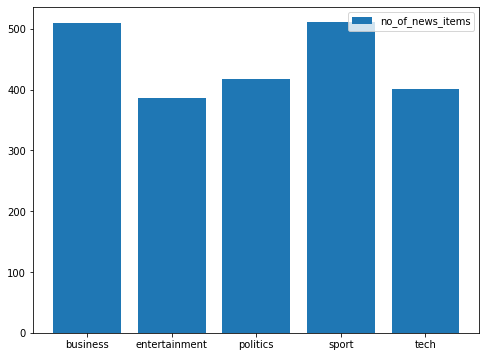

In [15]:
fig= plt.figure(figsize=(8,6))

plt.bar(chart.index, chart.content, label= 'no_of_news_items')
plt.legend()
plt.show ()

In [16]:
df['category_id']= df['category'].factorize()[0]

In [17]:
df = df[['content', 'category', 'category_id']]

In [18]:
df

,content,category,category_id
0,b'Greer attacks \'bully\' Big Brother\n\nGerma...,entertainment,0
0,"b""Byrds producer Melcher dies at 62\n\nRecord ...",entertainment,0
0,b'Brookside actress Keaveney dies\n\nActress A...,entertainment,0
0,b'Rapper Jay-Z becomes label boss\n\nRap star ...,entertainment,0
0,b'US actor Ossie Davis found dead\n\nUS actor ...,entertainment,0
...,...,...,...
0,"b""German growth goes into reverse\n\nGermany's...",business,4
0,b'Air passengers win new EU rights\n\nAir pass...,business,4
0,"b""Troubled Marsh under SEC scrutiny\n\nThe US ...",business,4
0,b'G7 backs Africa debt relief plan\n\nG7 finan...,business,4


##**Data Preprocessing**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

count_vectorizer = CountVectorizer(preprocessor=preprocess_text)

vectorizer = CountVectorizer(stop_words= 'english', decode_error= 'ignore', strip_accents='ascii', ngram_range=(1,2), max_df=0.8, min_df= 0.01, preprocessor=preprocess_text)




In [21]:
X = vectorizer.fit_transform(df['content'])
df_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [22]:
type(X), X.shape

(scipy.sparse.csr.csr_matrix, (2225, 3007))

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
features_new = tsne.fit_transform(df_bow)

In [24]:
df_tsne = pd.DataFrame(features_new)

In [25]:
df_tsne.columns= ['A','B']

In [26]:
df_tsne ['C'] = df['category_id'].values
df_tsne

,A,B,C
0,37.770802,-33.801426,0
1,34.788578,-22.743860,0
2,10.131623,-36.658932,0
3,-0.835222,-42.232647,0
4,-2.743052,-38.664303,0
...,...,...,...
2220,-29.957638,24.190353,4
2221,-12.687333,19.000528,4
2222,12.437696,30.900524,4
2223,39.329102,41.979893,4


In [27]:
group = df_tsne.groupby('C')

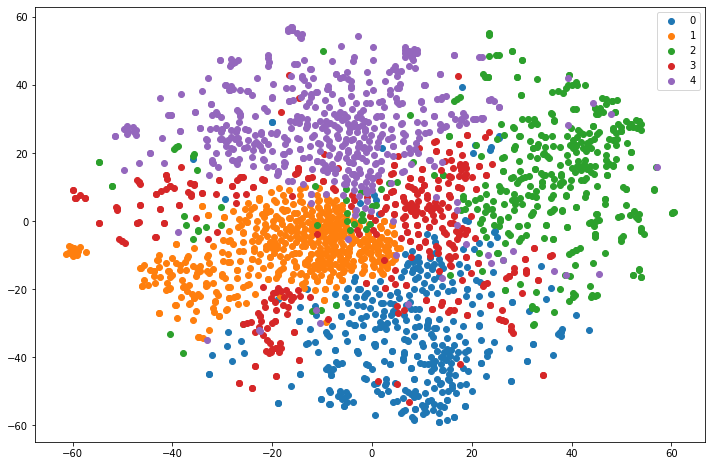

In [28]:
fig = plt.figure(figsize= (12,8))

for name, group in group:
  plt.scatter(group.A, group.B, label= name)
  plt.legend()


In [32]:
X.shape, type(X)

((2225, 3007), scipy.sparse.csr.csr_matrix)

In [33]:
features = df_bow
labels= df['category_id'].values

In [34]:
df_bow

,ability,able,abroad,absence,absolutely,abuse,academy,accept,accepted,access,according,account,accounting,accounts,accused,achieve,achieved,achievement,acknowledged,act,acting,action,actions,activities,activity,actor,actors,actress,acts,actually,add,added,adding,addition,additional,address,adds,administration,admitted,adopted,...,world,world biggest,world cup,world largest,world number,world said,world service,worldwide,worried,worries,worry,worrying,worse,worst,worth,wouldn,write,writer,writers,writing,written,wrong,wrote,xbox,year,year ago,year earlier,year old,year said,year year,years,years ago,yen,yes,york,young,young people,younger,yukos,zealand
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2222,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


##**Classification**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import classification_report

models = [
          ('KNN', KNeighborsClassifier()), ('SVC', SVC()), 
          ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=3 )), ('Gradient Descent',SGDClassifier()), ('Logistic Regression', LogisticRegression(random_state=0))
         ]
for name, model in models:
  model.fit(X_train, y_train)
  y_pred= model.predict(X_test)
  accuracy= accuracy_score(y_test, y_pred)
  print (name, accuracy)

KNN 0.6707482993197279
SVC 0.9591836734693877
Random Forest 0.8585034013605443
Gradient Descent 0.9714285714285714
Logistic Regression 0.9755102040816327
